# Coding Multi-Layer Perceptron in python
## (for a binary classification problem)

#### Forward propagation - model

- $Z^{[1]} = W^{[1]} X + b^{[1]}$
- $A^{[1]} = g^{[1]}(Z^{[1]})$
- $Z^{[2]} = W^{[2]} A^{[1]} + b^{[2]}$
- $A^{[2]} = g^{[2]}(Z^{[2]})$

where 
- $g^{[1]}$ is a ```Relu``` function (the code is provided)
- $g^{[2]}$ is a ```sigmoid``` function (the code is provided)



#### Parameters update

A **first version** in which the parameters are updated using a simple gradient descent:
- $W = W - \alpha dW$


A **second version** in which the parameters are updated using the momentum method
- $VdW(t) = \beta VdW(t-1) + (1-\beta) dW$
- $W) = W - \alpha VdW(t)$


# 1. Load packages

In [1]:
%matplotlib inline
import numpy as np
from sklearn import datasets
from sklearn import model_selection
import matplotlib.pyplot as plt 

# 2. Define a set of functions

In [2]:
def F_standardize(X):
    """
    standardize X, i.e. subtract mean (over data) and divide by standard-deviation (over data)
    
    Parameters
    ----------
    X: np.array of size (nbData, nbDim)
        matrix containing the observation data
    
    Returns
    -------
    X: np.array of size (nbData, nbDim)
        standardize version of X
    """
    
    X -= np.mean(X, axis=0, keepdims=True) 
    X /= (np.std(X, axis=0, keepdims=True) + 1e-16)
    return X

In [3]:
def F_sigmoid(x):
    """Compute the value of the sigmoid activation function"""
    return 1 / (1 + np.exp(-x))

def F_relu(x):
    """Compute the value of the Rectified Linear Unit activation function"""
    return x * (x > 0)

def F_dRelu(x):
    """Compute the derivative of the Rectified Linear Unit activation function"""
    x[x<=0] = 0
    x[x>0] = 1
    return x

def F_computeCost(hat_y, y):
    """Compute the cost (sum of the losses)
    
    Parameters
    ----------
    hat_y: (1, nbData)
        predicted value by the MLP
    y: (1, nbData)
        ground-truth class to predict
    """
    m = y.shape[1]
     
    loss = -(y * np.log(hat_y) + (1-y)*np.log(1-hat_y))     # Binary cross entropy
    
    cost = np.sum(loss) / m
    return cost

def F_computeAccuracy(hat_y, y):
    """Compute the accuracy
    
    Parameters
    ----------
    hat_y: (1, nbData)
        predicted value by the MLP
    y: (1, nbData)
        ground-truth class to predict
    """
    
    m = y.shape[0]    
    class_y = np.copy(hat_y)
    class_y[class_y>=0.5]=1
    class_y[class_y<0.5]=0
    return np.sum(class_y==y) / m

# 3. Load dataset and pre-process it

In [4]:
X, y = datasets.make_circles(n_samples=1000, noise=0.05, factor=0.5)

print("X.shape: {}".format(X.shape))
print("y.shape: {}".format(y.shape))
print(set(y))

# X is (nbExamples, nbDim)
# y is (nbExamples,)

# --- Standardize data
X = F_standardize(X)

# --- Split between training set and test set
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2)

# --- Convert to proper shape: (nbExamples, nbDim) -> (nbDim, nbExamples)
X_train = X_train.T
X_test = X_test.T

# --- Convert to proper shape: (nbExamples,) -> (1, nbExamples)
y_train = y_train.reshape(1, len(y_train))
y_test = y_test.reshape(1, len(y_test))

# --- Convert to oneHotEncoding: (1, nbExamples) -> (nbClass, nbExamples)
n_in = X_train.shape[0]
n_out = 1

print("X_train.shape: {}".format(X_train.shape))
print("X_test.shape: {}".format(X_test.shape))
print("y_train.shape: {}".format(y_train.shape))
print("y_test.shape: {}".format(y_test.shape))
print("y_train.shape: {}".format(y_train.shape))
print("y_test.shape: {}".format(y_test.shape))
print("n_in: {} n_out: {}".format(n_in, n_out))

X.shape: (1000, 2)
y.shape: (1000,)
{0, 1}
X_train.shape: (2, 800)
X_test.shape: (2, 200)
y_train.shape: (1, 800)
y_test.shape: (1, 200)
y_train.shape: (1, 800)
y_test.shape: (1, 200)
n_in: 2 n_out: 1


# 4. Define the MLP class with forward, backward and update methods

In [5]:
class C_MultiLayerPerceptron:
    """
    A class used to represent a Multi-Layer Perceptron with 1 hidden layers

    ...

    Attributes
    ----------
    W1, b1, W2, b2:
        weights and biases to be learnt
    Z1, A1, Z2, A2:
        values of the internal neurons to be used for backpropagation
    dW1, db1, dW2, db2, dZ1, dZ2:
        partial derivatives of the loss w.r.t. parameters
    VdW1, Vdb1, VdW2, Vdb2:
        momentum terms
    do_bin0_multi1:
        set wether we solve a binary or a multi-class classification problem
        
    Methods
    -------
    forward_propagation
    
    backward_propagation
    
    update_parameters
    
    """

    W1, b1, W2, b2 = [], [], [], []
    Z1, A1, Z2, A2 = [], [], [], []
    dW1, db1, dW2, db2 = [], [], [], []   
    dZ1, dA1, dZ2 = [], [], []
    # --- for momentum
    VdW1, Vdb1, VdW2, Vdb2 = [], [], [], []     
    
    def __init__(self, n_in, n_h, n_out):
        self.W1 = np.random.randn(n_in, n_h) * 0.01
        print('W1',self.W1.shape)
        self.b1 = np.zeros(shape=(1, n_h))
        print('b1',self.b1.shape)
        self.W2 = np.random.randn(n_h, n_out) * 0.01
        print('W2',self.W2.shape)
        self.b2 = np.zeros(shape=(1, n_out))        
        print('b2',self.b2.shape)
        # --- for momentum
        self.VdW1 = np.zeros(shape=(n_in, n_h)) 
        self.Vdb1 = np.zeros(shape=(1, n_h))
        self.VdW2 = np.zeros(shape=(n_h, n_out))
        self.Vdb2 = np.zeros(shape=(1, n_out))
        return

    
    def __setattr__(self, attrName, val):
        if hasattr(self, attrName):
            self.__dict__[attrName] = val
        else:
            raise Exception("self.%s note part of the fields" % attrName)

            

    def M_forwardPropagation(self, X):
        """Forward propagation in the MLP

        Parameters
        ----------
        X: numpy array (nbDim, nbData) 
            observation data

        Return
        ------
        hat_y: numpy array (1, nbData)
            predicted value by the MLP
        """
        

        self.Z1 = X.T @ self.W1 + self.b1 
        self.A1 = F_relu(self.Z1)
        self.Z2 = self.A1 @ self.W2 + self.b2
        self.A2 = F_sigmoid(self.Z2)        
        hat_y = self.A2
        return hat_y


    def M_backwardPropagation(self, X, y):
        """Backward propagation in the MLP

        Parameters
        ----------
        X: numpy array (nbDim, nbData)
            observation data
        y: numpy array (1, nbData)
            ground-truth class to predict
            
        """
        
        m = y.shape[1]    
        self.dZ2 = self.A2 - y.T   
        self.dW2 = (1/self.A1.shape[0]) * self.A1.T @ self.dZ2
        self.db2 = np.array((1/self.dZ2.shape[0]) * np.sum(self.dZ2)).reshape((1,1))
        self.dA1 = self.dZ2 @ np.transpose(self.W2)
        self.dZ1 = self.dA1 * F_dRelu(self.Z1)
        self.dW1 = (1/X.shape[1]) * X @ self.dZ1
        self.db1 = (1/self.dZ1.shape[0]) * np.sum(self.dZ1, axis = 0).reshape((1,10))
        return

    
    def M_gradientDescent(self, alpha):
        """Update the parameters of the network using gradient descent

        Parameters
        ----------
        alpha: float scalar
            amount of update at each step of the gradient descent
            
        """

        self.W1 = self.W1 - alpha * self.dW1
        self.b1 = self.b1 - alpha * self.db1     
        self.W2 = self.W2 - alpha * self.dW2
        self.b2 = self.b2 - alpha * self.db2        
        return

    
    def M_momentum(self, alpha, beta):
        """Update the parameters of the network using momentum method

        Parameters
        ----------
        alpha: float scalar
            amount of update at each step of the gradient descent
        beta: float scalar
            momentum term 
        """
        
        self.VdW1 = beta * self.VdW1 + (1-beta)*self.dW1
        self.W1 = self.W1 - alpha * self.VdW1

        self.Vdb1 = beta * self.Vdb1 + (1-beta)*self.db1
        self.b1 = self.b1 - alpha * self.Vdb1
        
        self.VdW2 = beta * self.VdW2 + (1-beta)*self.dW2
        self.W2 = self.W2 - alpha * self.VdW2
        
        self.Vdb2 = beta * self.Vdb2 + (1-beta)*self.db2
        self.b2 = self.b2 - alpha * self.Vdb2
        return
                

# 5. Perform training using batch-gradiant and epochs

In [6]:
# Instantiate the class MLP with providing 
# the size of the various layers (input=4, hidden=10, outout=1) 

n_hidden = 10
num_epoch = 5000


myMLP = C_MultiLayerPerceptron(n_in, n_hidden, n_out)

train_cost, train_accuracy, test_cost, test_accuracy = [], [], [], []

# Run over epochs
for i in range(0, num_epoch):
    
    # --- Forward
    hat_y_train = myMLP.M_forwardPropagation(X_train)
    
    # --- Store results on train
    train_cost.append( F_computeCost(hat_y_train, y_train.T) )
    train_accuracy.append( F_computeAccuracy(hat_y_train, y_train.T) )
    
    # --- Backward
    myMLP.M_backwardPropagation(X_train, y_train)
    
    # --- Update
    #myMLP.M_gradientDescent(alpha=0.1)
    myMLP.M_momentum(alpha=0.1, beta=0.9)

    # --- Store results on test
    hat_y_test = myMLP.M_forwardPropagation(X_test)
    test_cost.append( F_computeCost(hat_y_test, y_test.T) )    
    test_accuracy.append( F_computeAccuracy(hat_y_test, y_test.T) )
    
    if (i % 500)==0: 
        print("epoch: {0:d} (cost: train {1:.2f} test {2:.2f}) (accuracy: train {3:.2f} test {4:.2f})".format(i, train_cost[-1], test_cost[-1], train_accuracy[-1], test_accuracy[-1]))

W1 (2, 10)
b1 (1, 10)
W2 (10, 1)
b2 (1, 1)
epoch: 0 (cost: train 554.54 test 138.63) (accuracy: train 0.49 test 0.52)
epoch: 500 (cost: train 543.45 test 135.47) (accuracy: train 0.54 test 0.56)
epoch: 1000 (cost: train 283.50 test 71.76) (accuracy: train 1.00 test 1.00)
epoch: 1500 (cost: train 76.81 test 19.77) (accuracy: train 1.00 test 1.00)
epoch: 2000 (cost: train 32.97 test 8.61) (accuracy: train 1.00 test 1.00)
epoch: 2500 (cost: train 18.55 test 4.95) (accuracy: train 1.00 test 1.00)
epoch: 3000 (cost: train 12.24 test 3.34) (accuracy: train 1.00 test 1.00)
epoch: 3500 (cost: train 8.91 test 2.48) (accuracy: train 1.00 test 1.00)
epoch: 4000 (cost: train 6.92 test 1.97) (accuracy: train 1.00 test 1.00)
epoch: 4500 (cost: train 5.61 test 1.63) (accuracy: train 1.00 test 1.00)


## Display train/test loss and accuracy

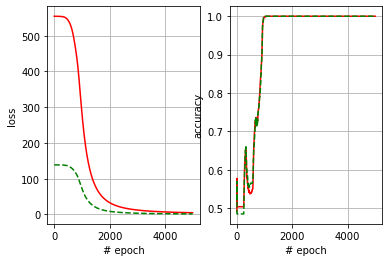

In [7]:
plt.subplot(1,2,1)
plt.plot(train_cost, 'r')
plt.plot(test_cost, 'g--')
plt.xlabel('# epoch')
plt.ylabel('loss')
plt.grid(True)
plt.subplot(1,2,2)
plt.plot(train_accuracy, 'r')
plt.plot(test_accuracy, 'g--')
plt.xlabel('# epoch')
plt.ylabel('accuracy')
plt.grid(True)